# Programming Assignment 3b: Sentiment Classification

**Members:** Michael Hoon Yong Hau (yongm@chalmers.se), Chua Shan Hong (shanho@chalmers.se)

**PA3b Group 5**

# Exploratory Data Analysis

## Data Processing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load data
crowd = pd.read_csv("crowdsourced_train.csv", sep="\t")
gold = pd.read_csv("gold_train.csv", sep="\t")
test = pd.read_csv("test.csv", sep="\t")

# Merge for comparison
merged = crowd.merge(gold, on="text", suffixes=("_crowd", "_gold"))

In [ ]:
crowd.head()

,sentiment,text
0,Positive,There's so much misconception on Islam rn so s...
1,Positive,@Mr_Rondeau You should try Iron Maiden at abou...
2,Negative,Going to #FantasticFour tomorrow. Half expecti...
3,Neutral,"@cfelan hey hey, just checkng to see if you or..."
4,Positive,does anyone just get drunk and watch twilight ...


In [ ]:
crowd.describe()

,sentiment,text
count,10676,10676
unique,37,10676
top,neutral,"And yet, I have yet to see the whole series of..."
freq,2671,1


## Label Distribution Analysis

In [ ]:
crowd_sentiment_categories = crowd['sentiment'].unique()

print("Crowdsourced Sentiment Categories:", crowd_sentiment_categories)

gold_sentiment_categories = gold['sentiment'].unique()

print("Gold Sentiment Categories:", gold_sentiment_categories)

Crowdsourced Sentiment Categories: ['Positive' 'Negative' 'Neutral' 'neutral' 'negative' 'positive'
 'neutral?' 'Nuetral' 'negative ' 'positive ' 'neutral ' ' negative'
 'Nedative' '_x0008_neutral' 'netural' 'netutral' 'Neutral ' 'Neural'
 'Neutrall' 'Netural' 'neugral' 'neutrla' 'negtaive' 'postive'
 '                neutral'
 '                                        positive' '    positive'
 ' neutral' '               negative' 'Nutral' 'negayive' 'positie'
 'neutra l' 'npositive' 'neutal' 'postitive' 'Positve']
Gold Sentiment Categories: ['neutral' 'positive' 'negative']


We see that in the crowdsourced sentiment categories, there are more than the 3 supposed values of "positive", "negative", and "neutral". We need to clean the dataset and remove the incorrect labels. Since there are only a few incorrectly spelled labels, we will manually find and replace the labels appropriately by using a mapping dictionary.


In [ ]:
import re

def clean_sentiment(label):
    clean = str(label).strip().lower()

    # remove non-alphabetical characters except letters
    clean = re.sub(r'[^a-z]', '', clean)

    corrections = {
        'nuetral': 'neutral',
        'nedative': 'negative',
        'netural': 'neutral',
        'netutral': 'neutral',
        'neural': 'neutral',
        'neutrall': 'neutral',
        'neugral': 'neutral',
        'neutrla': 'neutral',
        'negtaive': 'negative',
        'postive': 'positive',
        'nutral': 'neutral',
        'negayive': 'negative',
        'positie': 'positive',
        'neutra': 'neutral',
        'npositive': 'positive',
        'neutal': 'neutral',
        'postitive': 'positive',
        'positve': 'positive',
        'xneutral': 'neutral'
    }

    return corrections.get(clean, clean)

crowd['sentiment'] = crowd['sentiment'].apply(clean_sentiment)

In [ ]:
print(crowd['sentiment'].unique())

['positive' 'negative' 'neutral']


Here we can finally see that the labels are now appropriately cleaned. Next, we plot the distribution of labels as follows using a pie chart:

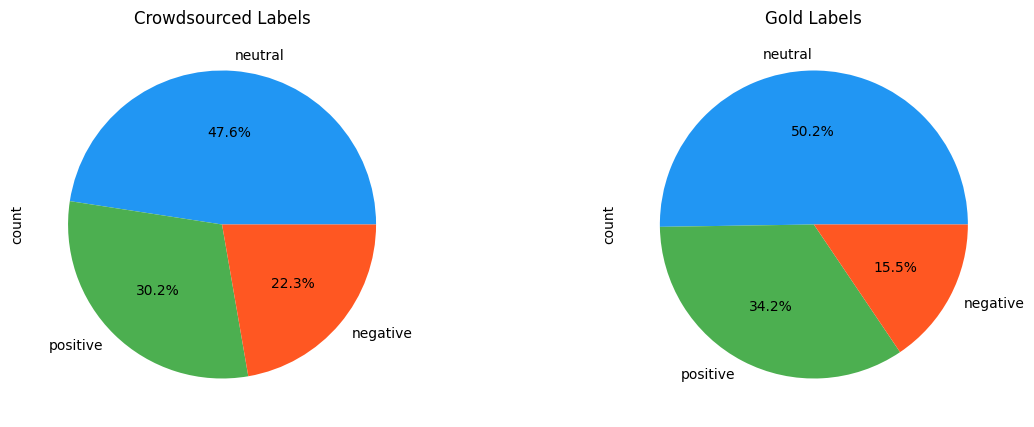

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

crowd["sentiment"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", ax=ax[0],
    colors=["#2196F3", "#4CAF50", "#FF5722"]
)
ax[0].set_title("Crowdsourced Labels")

gold["sentiment"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", ax=ax[1],
    colors=["#2196F3", "#4CAF50", "#FF5722"]
)
ax[1].set_title("Gold Labels")

plt.show()

Below we show the actual sentiment counts for both the crowdsourced and gold labels.

In [ ]:
sentiment_counts = crowd["sentiment"].value_counts()
print("Crowdsourced Sentiment Counts:")
print(sentiment_counts)

sentiment_counts = gold["sentiment"].value_counts()
print("\nGold Sentiment Counts:")
print(sentiment_counts)

Crowdsourced Sentiment Counts:
sentiment
neutral     5079
positive    3219
negative    2378
Name: count, dtype: int64

Gold Sentiment Counts:
sentiment
neutral     5364
positive    3652
negative    1660
Name: count, dtype: int64


Here we see that for both the crowdsourced and gold labels, roughly half of them were labelled as "neutral", and with more positive labels compared to negative labels.

For the gold standard labels, there is a stronger neutral bias from the annotator (since we are treating it as a single labeller, different from the crowdsourced one). The gold data also contains 433 more positive examples, and fewer negative examples (1660 vs. 2378 in crowdsourced). This discrepancy could lead to differences when training models on each dataset. The model trained on crowdsourced data might overpredict negative sentiment compared to the gold-trained model (we will see this in the next sections).

## Annotator Agreement Metric

To measure inter-rater reliability, we will use the cohen's kappa value. **Cohen's Kappa** is a measure of agreement between two dependent categorical samples. We will also plot a confusion matrix to see the exact disagreements between the gold standard and the crowdsource annotated data.

Cohen's κ: 0.19


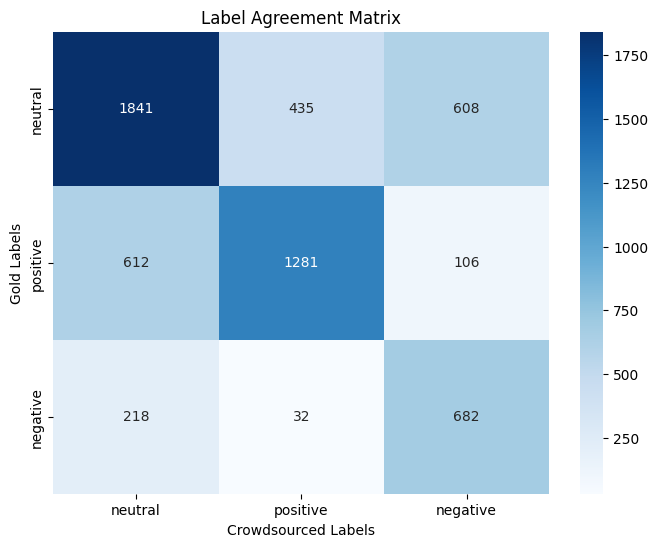

In [ ]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

conf_matrix = confusion_matrix(
    merged["sentiment_gold"],
    merged["sentiment_crowd"],
    labels=["neutral", "positive", "negative"]
)

plt.figure(figsize=(8,6))
sns.heatmap(
    conf_matrix, annot=True, fmt="d",
    xticklabels=["neutral", "positive", "negative"],
    yticklabels=["neutral", "positive", "negative"],
    cmap="Blues"
)
plt.xlabel("Crowdsourced Labels")
plt.ylabel("Gold Labels")
plt.title("Label Agreement Matrix")

kappa = cohen_kappa_score(merged["sentiment_gold"], merged["sentiment_crowd"])
print(f"Cohen's κ: {kappa:.2f}")

Cohen's Kappa, κ, is 0.45, which is **moderate agreement**. The label agreement matrix shows the highest agreement for neutral (3504 correct) but significant confusion between neutral and negative (996 gold neutrals are crowdsourced negatives - 18.5% mislabelled) and between positive and neutral (1174 gold positives labeled as neutral in crowdsourced - 32.1% of total positives mislabelled). This suggests that distinguishing neutral from positive/negative is challenging for annotators, maybe due to ambiguous tweets.

## Text Length Analysis

Crowdsourced Data:
sentiment
negative    21.0
neutral     20.0
positive    20.0
Name: text_length, dtype: float64

Gold Data:
sentiment
negative    21.0
neutral     20.0
positive    20.0
Name: text_length, dtype: float64


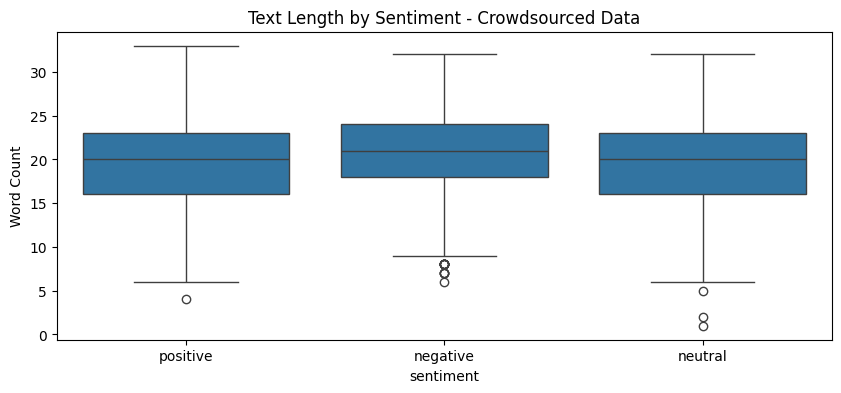

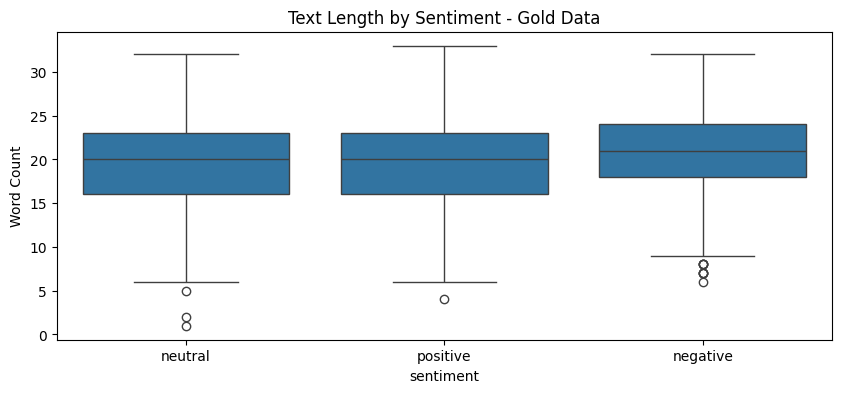

In [ ]:
def plot_length_distribution(df, title):
    df["text_length"] = df["text"].apply(lambda x: len(x.split()))
    plt.figure(figsize=(10, 4))
    sns.boxplot(x="sentiment", y="text_length", data=df)
    plt.title(f"Text Length by Sentiment - {title}")
    plt.ylabel("Word Count")

plot_length_distribution(crowd, "Crowdsourced Data")
plot_length_distribution(gold, "Gold Data")

print("Crowdsourced Data:")
print(crowd.groupby("sentiment")["text_length"].median())
print("\nGold Data:")
print(gold.groupby("sentiment")["text_length"].median())

We see that negative tweets are slightly longer in both datasets. This might be because negative sentiments are expressed with more words, (maybe due to explanations or complaints). However, the difference is not significant, so it might not be a critical issue.

## Lexical Analysis

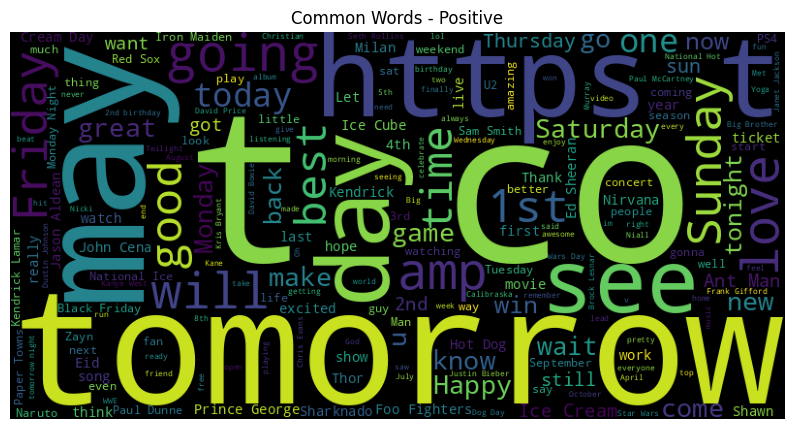

In [ ]:
def plot_word_cloud(df, sentiment):
    text = " ".join(df[df["sentiment"]==sentiment]["text"])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Common Words - {sentiment.capitalize()}")

# Crowdsourced positive words
plt.figure(figsize=(10, 6))
plot_word_cloud(crowd, "positive")

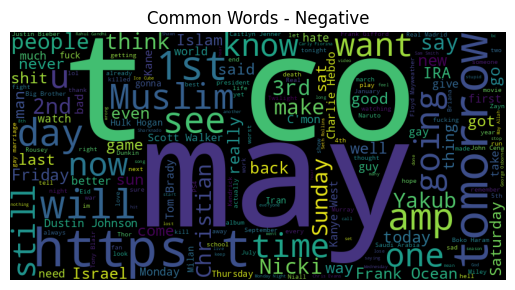

In [ ]:
plot_word_cloud(crowd, "negative")

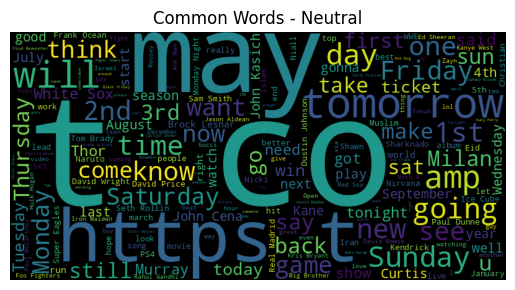

In [ ]:
plot_word_cloud(crowd, "neutral")

Text(0.5, 1.0, 'Sentiment Distribution for Top 10 Hashtags')

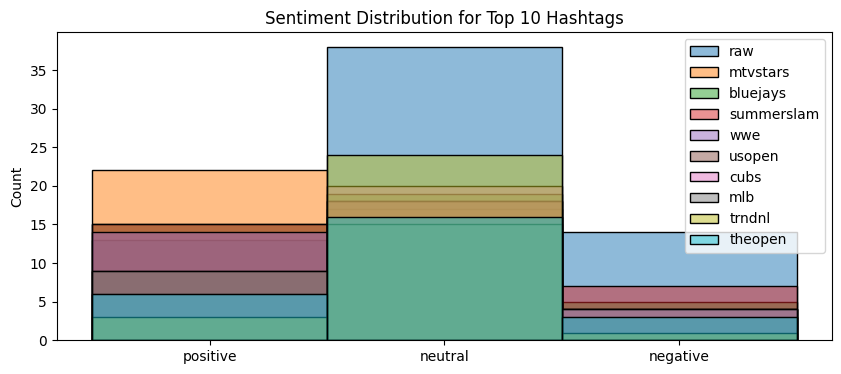

In [ ]:
from collections import defaultdict

def extract_hashtags(text):
    return re.findall(r"#(\w+)", text.lower())

hashtag_db = defaultdict(list)
for _, row in crowd.iterrows():
    for tag in extract_hashtags(row["text"]):
        hashtag_db[tag].append(row["sentiment"])

top_tags = sorted(hashtag_db.items(), key=lambda x: len(x[1]), reverse=True)[:10]

plt.figure(figsize=(10, 4))
for tag, sentiments in top_tags:
    sns.histplot(sentiments, label=tag, alpha=0.5, bins=3)
plt.legend()
plt.title("Sentiment Distribution for Top 10 Hashtags")

## Model Development Considerations & Takeaways

**Class Imbalance**: Negative class has lowest representation in both datasets, thus there is a need for class weighting or oversampling etc

**Feature Design**: Tweet length is non-discriminative, here we should focus on lexical features instead